<style>
.group {
  margin: 0 auto;
  font-size: 1vh;
  display: -webkit-box;
  display: -webkit-flex;
  display: -ms-flexbox;
  display: flex;
  -webkit-box-orient: vertical;
  -webkit-box-direction: normal;
  -webkit-flex-direction: column;
      -ms-flex-direction: column;
          flex-direction: column;
  -webkit-box-pack: start;
  -webkit-justify-content: flex-start;
      -ms-flex-pack: start;
          justify-content: flex-start;
  max-width: 100vh;
  max-height: 100vh;
  height: 200vw;
}
.group img {
  width: 100%;
  border: 2px solid transparent;
  margin: 0;
  box-sizing: border-box;
}
.group .features, .group .crops {
  display: -webkit-box;
  display: -webkit-flex;
  display: -ms-flexbox;
  display: flex;
  -webkit-box-align: center;
  -webkit-align-items: center;
      -ms-flex-align: center;
          align-items: center;
  -webkit-box-orient: horizontal;
  -webkit-box-direction: normal;
  -webkit-flex-direction: row;
      -ms-flex-direction: row;
          flex-direction: row;
}
.group .features {
  max-height: 150px;
  -webkit-box-ordinal-group: 2;
  -webkit-order: 1;
      -ms-flex-order: 1;
          order: 1;
}
.group .features img {
  -webkit-box-flex: 1;
  -webkit-flex: 1;
      -ms-flex: 1;
          flex: 1;
  border-radius: 100%;
}
.group .crops {
  -webkit-box-ordinal-group: 3;
  -webkit-order: 2;
      -ms-flex-order: 2;
          order: 2;
}
.group .sourceimg {
  -webkit-box-ordinal-group: 4;
  -webkit-order: 3;
      -ms-flex-order: 3;
          order: 3;
  -webkit-box-flex: 1;
  -webkit-flex: 1 0 0;
      -ms-flex: 1 0 0;
          flex: 1 0 0;
  -o-object-fit: contain;
     object-fit: contain;
  -o-object-position: 50% 0%;
     object-position: 50% 0%;
}
</style>

In [2]:
from PIL import Image, ImageOps, ImageDraw
from jinja2 import Template
from io import BytesIO
import random
import itertools
import glob
import cv2
import base64
import os, shutil
from hashlib import md5

In [3]:
class BoundingBox:

    """Rectangular bounding box"""

    def __init__(self, left, top, right, bottom):
        if top > bottom or left > right:
            raise ValueError(
                'Width and height must be greater than zero')
        self.left = left
        self.top = top
        self.right = right
        self.bottom = bottom

    def __repr__(self):
        return (
            '{self.__class__.__name__}'
            '(left={self.left}, top={self.top}, '
            'right={self.right}, bottom={self.bottom})'
        ).format(self=self)

    def __add__(self, other):
        """BoundingBox containing both boxes"""
        return self.__class__(
            left=min(self.left, other.left),
            top=min(self.top, other.top),
            right=max(self.right, other.right),
            bottom=max(self.bottom, other.bottom),
        )

    def __radd__(self, other):
        return self

    def __and__(self, other):
        """Intersection"""
        return self.__class__(
            left=max(self.left, other.left),
            top=max(self.top, other.top),
            right=min(self.right, other.right),
            bottom=min(self.bottom, other.bottom),
        )

    def __contains__(self, point):
        return (self.top <= point[0] <= self.bottom and
                self.left <= point[1] <= self.right)

    def __mul__(self, factor):
        """Multiply all dimensions by factor"""
        x, y = self.center
        w, h = self.width * factor, self.height * factor
        return self.__class__(
            left=x - w / 2,
            top=y - h / 2,
            right=x + w / 2,
            bottom=y + h / 2,
        )

    @property
    def width(self):
        return self.right - self.left

    @width.setter
    def width(self, value):
        self.left, self.right = (
            self.center[0] + x * value * .5 for x in [-1, 1])

    @property
    def height(self):
        return self.bottom - self.top

    @height.setter
    def height(self, value):
        self.top, self.bottom = (
            self.center[1] + x * value * .5 for x in [-1, 1])

    @property
    def diagonal(self):
        """Length of diagonal"""
        return (self.width**2 + self.height**2)**0.5

    @property
    def ratio(self):
        """Aspect ratio"""
        return self.width / self.height

    @property
    def size(self):
        """Area of BoundingBox"""
        return self.width * self.height

    @property
    def center(self):
        """Center point of box (x, y)"""
        return (self.right + self.left) / 2, (self.bottom + self.top) / 2

    @property
    def geometry(self):
        return self.left, self.top, self.right, self.bottom

    def inside(self, other, fit=True):
        LIMIT = 1e-15  # floating point math requires some imprecision
        if not fit:
            assert self.width - other.width > -LIMIT
            assert self.height - other.height > -LIMIT

        width = min(self.width, other.width,
                    other.ratio * self.height)
        height = width * other.ratio**-1.0
        left = sorted([self.left, self.right - width,
                       other.center[0] - width / 2])[1]
        top = sorted([self.top, self.bottom - height,
                      other.center[1] - height / 2])[1]
        right = left + width
        bottom = top + height
        return self.__class__(left, top, right, bottom)

    def outside(self, other, fit=True):
        LIMIT = 1e-15  # floating point math requires some imprecision
        if not fit:
            assert other.width - self.width > -LIMIT
            assert other.height - self.height > -LIMIT

        width = max(self.width, other.width,
                    other.ratio * self.height)
        height = width * other.ratio**-1.0
        left = sorted([self.left, self.right - width,
                       other.center[0] - width / 2])[1]
        top = sorted([self.top, self.bottom - height,
                      other.center[1] - height / 2])[1]
        right = left + width
        bottom = top + height
        return self.__class__(left, top, right, bottom)


class ImageBoundingBox(BoundingBox):

    """Bounding box with absolute pixel values"""

    @classmethod
    def from_relative(cls, box, image_width, image_height, contain=True):
        if contain:
            box &= BoundingBox(0, 0, 1, 1)

        return cls(
            left=box.left * image_width,
            top=box.top * image_height,
            right=box.right * image_width,
            bottom=box.bottom * image_height,
        )

    def to_relative(self, image_width, image_height, contain=True):
        """Convert to a RelativeBoundingBox"""
        box = BoundingBox(
            left=self.left / image_width,
            top=self.top / image_height,
            right=self.right / image_width,
            bottom=self.bottom / image_height,
        )
        if contain:
            box &= BoundingBox(0, 0, 1, 1)

        return box

In [4]:
class BaseCropEngine:

    def __init__(self, padding=0.6):
        self.bounds = BoundingBox(0, 0, 1, 1) * padding

    @staticmethod
    def opencv_image(image_file, size, color=cv2.COLOR_BGR2GRAY):
        cvimg = cv2.imread(image_file)
        height, width = cvimg.shape[:2]
        if width > height:
            height, width = size * height // width, size
        else:
            height, width = size, size * width // height
        cvimg = cv2.resize(cvimg, (width, height))
        return cv2.cvtColor(cvimg, color)

    def find_features(self, image_file):
        return [self.bounds, self.bounds * 0.5]

In [6]:
class FeatureCropEngine(BaseCropEngine):

    def __init__(self, n=10, padding=1.2, size=200, extra_kwargs=None):
        self.imagesize = size
        self.padding = padding
        arguments = dict(
            nfeatures=n,
            scaleFactor=1.5,
            patchSize=self.imagesize // 10,
            edgeThreshold=self.imagesize // 10,
            WTA_K=2,
            scoreType=cv2.ORB_FAST_SCORE,
        )
        if extra_kwargs:
            arguments.update(extra_kwargs)
        self.feature_detector = cv2.ORB_create(**arguments)

    def find_features(self, image_file):
        cvimg = self.opencv_image(
            image_file, self.imagesize)
        height, width = cvimg.shape[:2]
        keypoints, desc = self.feature_detector.detectAndCompute(
            image=cvimg, mask=None)

        def keyfunc(kp):
            return kp.size * kp.response ** 2
        keypoints = sorted(
            keypoints,  key=keyfunc, reverse=True)

        boxes = []
        for keypoint in keypoints:
            radius = keypoint.size / 2
            x = keypoint.pt[0]
            y = keypoint.pt[1]
            box = ImageBoundingBox(
                left=x - radius,
                top=y - radius,
                right=x + radius,
                bottom=y + radius,
            )
            box *= self.padding
            box = box.to_relative(width, height)
            boxes.append(box)

        return boxes

In [7]:
class FaceCropEngine(BaseCropEngine):

    cascade_files = '/usr/share/opencv/haarcascades/haarcascade_{}.xml'
    default_classifiers = ['frontalface_default', 'profileface']

    def __init__(self, classifiers=None, n=100, size=400, padding=1.3):
        if classifiers is None:
            classifiers = self.default_classifiers[:]
        self.classifiers = []
        for classifier_name in classifiers:
            cascade_file = self.cascade_files.format(
                classifier_name)
            self.classifiers.append(
                cv2.CascadeClassifier(cascade_file))

        self.imagesize = size
        self.minsize = (self.imagesize // 15,
                        self.imagesize // 15)
        self.padding = padding
        self.number = n

    def find_features(self, image_file):
        cvimg = self.opencv_image(
            image_file, self.imagesize)
        height, width = cvimg.shape[:2]

        faces = []
        for classifier in self.classifiers:
            faces.extend(
                classifier.detectMultiScale(
                    cvimg,
                    minSize=self.minsize,
                    minNeighbors=8,
                ))
        boxes = []
        for l, t, w, h in faces:
            box = ImageBoundingBox(
                left=l, top=t, right=l + w, bottom=t + h)
            box *= self.padding
            box = box.to_relative(width, height)
            boxes.append(box)

        boxes = sorted(
            boxes, key=lambda b: b.size, reverse=True)
        return boxes[:self.number]

In [8]:
class HybridEngine(BaseCropEngine):

    def __init__(self, padding=1.3):
        self.face_engine = FaceCropEngine(padding=padding)
        self.feature_engine = FeatureCropEngine(
            padding=padding)
        self.extra_engine = FeatureCropEngine(
            n=5, padding=padding / 2)

    def find_features(self, image_file, plot=None):
        features = self.face_engine.find_features(
            image_file)
        if not features:
            return self.feature_engine.find_features(image_file)
        if sum(features).size < 0.15:
            features += self.extra_engine.find_features(
                image_file)
        return features

In [9]:
def plot_box_on_image(image, box=None, color='white', shape='b', grid=2,
                      width=1, invert=False, antialias=2):
    width = width * antialias / 2
    if box is None:
        box = BoundingBox(0, 0, 1, 1)
    if isinstance(box, ImageBoundingBox):
        box = ImageBoundingBox.to_relative(
            box, image.width, image.height)
    overlay = Image.new(
        size=[int(dim * antialias) for dim in image.size],
        mode='RGBA', color=(0, 0, 0, 0))

    box = ImageBoundingBox.from_relative(
        box, overlay.width, overlay.height)
    draw = ImageDraw.Draw(overlay)

    def line(*args):
        draw.line(args, fill=color, width=int(2 * width))

    if 'o' in shape:
        b0 = [v - width for v in box.geometry]
        b1 = [v + width for v in box.geometry]
        draw.ellipse(b0[:2] + b1[2:], fill=color)
        draw.ellipse(b1[:2] + b0[2:], fill=(0, 0, 0, 0))

    if 'b' in shape:
        l, t, r, b = box.geometry
        line(l + width, t, r - width, t)
        line(l + width, b, r - width, b)
        line(l, t - width, l, b + width)
        line(r, t - width, r, b + width)

    if 'x' in shape:
        line(box.left, box.top, box.right, box.bottom)
        line(box.right, box.top, box.left, box.bottom)

    if '+' in shape:
        x, y = box.center
        length = 20 * antialias
        gap = 5 * antialias
        line(x - length, y, x - gap, y)
        line(x + length, y, x + gap, y)
        line(x, y - length, x, y - gap)
        line(x, y + length, x, y + gap)

    if grid and '#' in shape:
        divs = grid + 1
        dw = box.width / divs
        dh = box.height / divs
        for n in range(1, divs):
            x = box.left + n * dw
            y = box.top + n * dh
            line(box.left, y, box.right, y)
            line(x, box.top, x, box.bottom)

    overlay = overlay.resize(image.size, Image.LANCZOS)
    mask = overlay
    if invert:
        overlay = ImageOps.invert(image)
    image.paste(overlay, mask=mask)

In [10]:
def test_box_and_plotting(image_file):
    image = Image.open(image_file)
    image.thumbnail((600, 400))
    box = None
    plot_box_on_image(image, box, width=.8, shape='#',
                      color='white', grid=9, antialias=3)
    box = BoundingBox(.6, .1, .9, .6)
    box = ImageBoundingBox.from_relative(
        box * 2, image.width, image.height)
    plot_box_on_image(image, box, width=5, shape='ox',
                      color=(256, 0, 256, 128), antialias=4)
    box.height = box.width = 300
    plot_box_on_image(image, box * 0.5,
                      width=3, shape='o', antialias=4)
    plot_box_on_image(image, box, width=20,
                      shape='b+', invert=True)
    return image

In [11]:
def close_crop(image, geometry, center, shape):

    center_x = center[0] * image.width
    center_y = center[1] * image.height
    cropbox = ImageBoundingBox.from_relative(
        BoundingBox(*geometry), image.width, image.height)

    output_ratio = float(shape[0]) / shape[1]
    image_ratio = image.width / image.height

    if image_ratio > output_ratio:
        crop_to_image_width = image.height * output_ratio
    else:
        crop_to_image_width = image.width

    if cropbox.ratio > output_ratio:
        crop_to_region_width = cropbox.width
    else:
        crop_to_region_width = cropbox.height * output_ratio

    width = min(crop_to_image_width, crop_to_region_width)
    half_width = width / 2
    half_height = half_width / output_ratio

    if half_width * 2 > cropbox.width:
        ccx = [half_width, image.width -
               half_width, cropbox.center[0]]
    else:
        ccx = [cropbox.left + half_width,
               cropbox.right - half_width, center_x]

    if half_height * 2 > cropbox.height:
        ccy = [half_height, image.height -
               half_height, cropbox.center[1]]
    else:
        ccy = [cropbox.top + half_height,
               cropbox.bottom - half_height, center_y]

    center_x, center_y = sorted(ccx)[1], sorted(ccy)[1]

    box = BoundingBox(
        left=center_x - half_width,
        right=center_x + half_width,
        top=center_y - half_height,
        bottom=center_y + half_height,
    )
    return box

In [12]:
def image_crops_to_htmldiv(image):
    height = 150
    ratios = 0.5, 1, 2
    widths = (int(height * ratio) for ratio in ratios)
    center = image.features[0].center
    image_id = image.filename
    cropbox = sum(image.features) * 1.2
    crop_thumbs = []
    feature_thumbs = []
    for width in widths:
        shape = (width, height)
        box = close_crop(
            image=image,
            geometry=cropbox.geometry,
            center=center,
            shape=shape,
        )
        thumb = image.crop(
            [int(val) for val in box.geometry]).resize(shape)
        crop_thumbs.append(image_to_html_img(thumb))

    feature_thumb_size = [int(height * .5)] * 2
    imageclone = image.copy()
    image.thumbnail((height * 3, height * 3))
    plot_box_on_image(image, cropbox, color='white',
                      width=2, shape='b', antialias=4)
    plot_box_on_image(image, image.features[
                      0], color='yellow', width=1, shape='+', antialias=4)

    for index, feature in enumerate(image.features):
        box = ImageBoundingBox.from_relative(
            feature, imageclone.width, imageclone.height)
        thumb = imageclone.crop(
            [int(v) for v in box.geometry])
        thumb.thumbnail(feature_thumb_size)
        plot_box_on_image(
            image, feature, shape='o', antialias=4)
        plot_box_on_image(
            thumb, None, shape='+', antialias=4)
        feature_id = '{}-{}'.format(image_id, index)
        feature_thumbs.append(
            image_to_html_img(thumb, _id=feature_id))

    SNIPPET = """
    <div class='group'>
        <div class='thumbs'>
            <div class='crops'>{crops}</div>
            <div class='features'>{features}</div>
        </div>
        <div class='sourceimage'>{sourceimage}</div>
    </div>
    """

    sourceimage = image_to_html_img(image, _id=image_id)
    html = SNIPPET.format(
        crops=''.join(crop_thumbs),
        features=''.join(feature_thumbs),
        sourceimage=sourceimage,
    )
    return html

In [13]:
def image_to_data_uri(pil_image, file_format='jpeg'):
    blob = BytesIO()
    pil_image.convert('RGB').save(blob, file_format)
    data = base64.encodebytes(blob.getvalue()).decode(
        'ascii').replace('\n', '')
    return 'data:image/{0}/;base64,{1}'.format(file_format, data)

In [14]:
def save_image(pil_image, folder='thumbcache', file_format='jpeg'):
    os.makedirs(folder, exist_ok=True)
    blob = BytesIO()
    pil_image.convert('RGB').save(blob, file_format)
    fname = md5(blob.getvalue()).hexdigest()
    filepath = '{folder}/{fname}.{ext}'.format(
        folder=folder, fname=fname, ext=file_format
    )
    with open(filepath, 'wb') as fp:
        fp.write(blob.getvalue())
    return filepath

In [15]:
def image_crop_html(image, features):
    SNIPPET = """
    <div class='group'>
        <div class='crops'>
        {% for crop in crops %}
            <img 
                style='flex: {{ crop.ratio }}'
                src='{{ uri(crop.image) }}' 
            />
        {% endfor %}
        </div>
        <div class='features'>
        {% for feature in features %}
            <img src='{{ uri(feature.image) }}' />
        {% endfor %}
        </div>
        <img class='sourceimg' src='{{ uri(image) }}' />
    </div>
    """
    template = Template(SNIPPET)

    height = 200
    ratios = 0.5, 1.0, 2.5
    crop_center = features[0].center
    image_id = image.filename
    cropbox = BoundingBox(0, 0, 1, 1) & (
        sum(features) * 1.2)
    crops = []
    feature_thumbs = []
    for ratio in ratios:
        width = int(height * ratio)
        shape = (width, height)
        box = close_crop(
            image, cropbox.geometry, crop_center, shape)
        geometry = [int(val) for val in box.geometry]
        thumb = image.crop(geometry).resize(shape, 2)
        crops.append({'ratio': ratio, 'image': thumb, })

    for index, feature in enumerate(features):
        box = ImageBoundingBox.from_relative(
            feature, image.width, image.height)
        thumb = image.crop([int(v) for v in box.geometry])
        thumb.thumbnail([int(height * .6)] * 2)
        feature_thumbs.append({
            'title': index,
            'image': thumb,
        })

    html = template.render(
        image=image,
        features=feature_thumbs,
        crops=crops,
        # uri=save_image,
        uri=image_to_data_uri,
    )
    return html


def main(n=10, image_files=None, random_order=False):
    resize = 500, 500
    crop_engine = HybridEngine(padding=1.5)
    shutil.rmtree('thumbcache', ignore_errors=True)
    if image_files is None:
        image_files = pinterestimages

    if random_order:
        random.shuffle(image_files)

    image_files = image_files[:n]

    images = []
    for image_file in image_files:
        image = Image.open(image_file).convert('RGB')
        image.filename = image_file
        image.thumbnail(resize)
        features = crop_engine.find_features(image_file)
        image.html = image_crop_html(image, features)
        images.append(image)

    return '\n'.join(im.html for im in images)


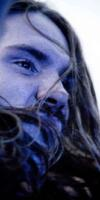
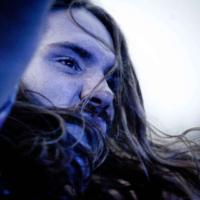
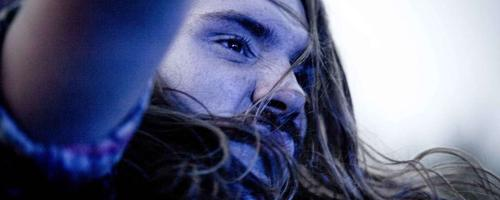
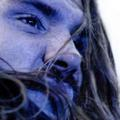
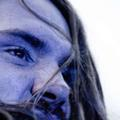
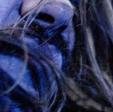
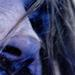
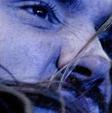
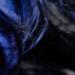
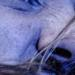
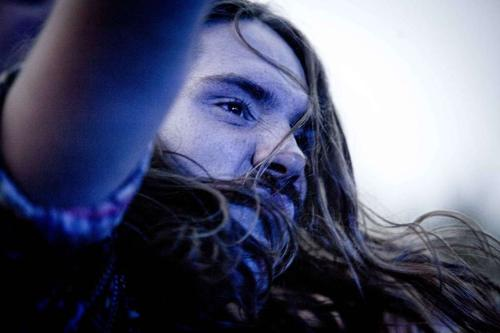
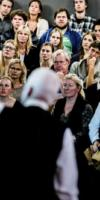
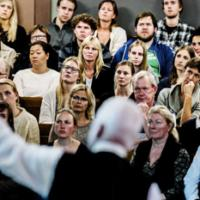
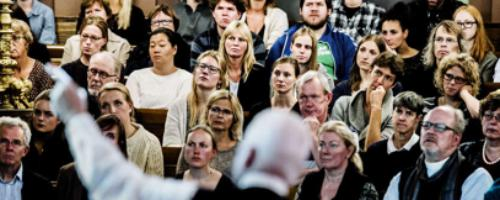
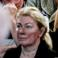
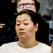
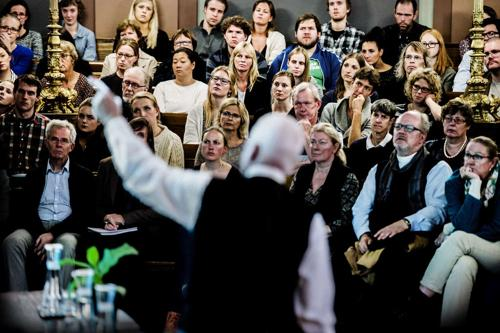

In [20]:
from IPython.display import HTML, display
tassenbilder = glob.glob('/srv/fotoarkiv_universitas/2014/**/*.jpg')
pinterestimages = glob.glob('./pinterest/*.jpg')
flickrimages = glob.glob('./crop-photos/*.jpg')
html = main(2, image_files=tassenbilder, random_order=True)
HTML(html)